In [1]:
cd ..

/home/martin/inference_langevin


### Setup

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

from langevin.plot_results import plot_results, plot_l1_tuning


plt.rcParams['figure.figsize'] = [6, 5]

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

mpl.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

Samples used: 100


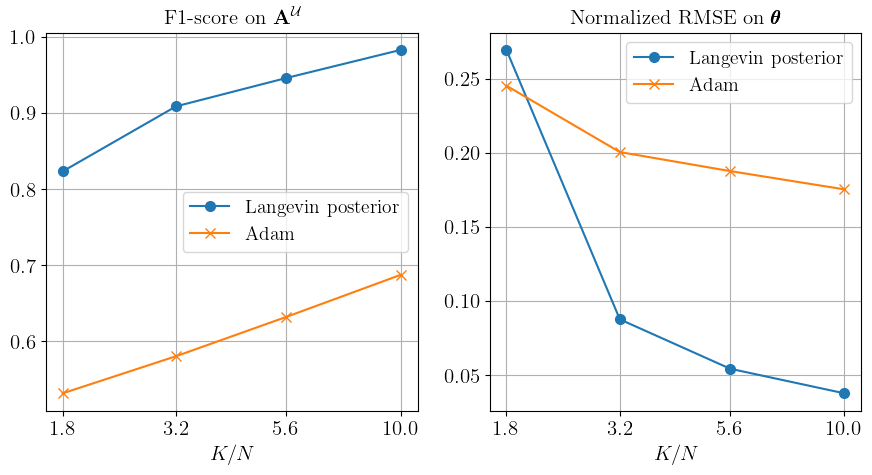

In [5]:
thresholds = {
    "langevin_posterior": 0.5,
    "adam": 0.5,
}
legend = {
    "langevin_posterior": "Langevin posterior",
    "adam": "Adam",
}

filename = f"outputs/full_estimation_deezer_ego_1994_0.01_1_25_1.0_(0.3, 0.7)_heat_diffusion_filter.csv"

plot_results(filename, legend, figsize=(9, 5), x_label="obs_ratio", theta_metric="mse", 
             thresholds=thresholds, output=None, pad_inches=0.04,
             styles=["o-", "x-"])
plt.show()

Number of simulations: 100


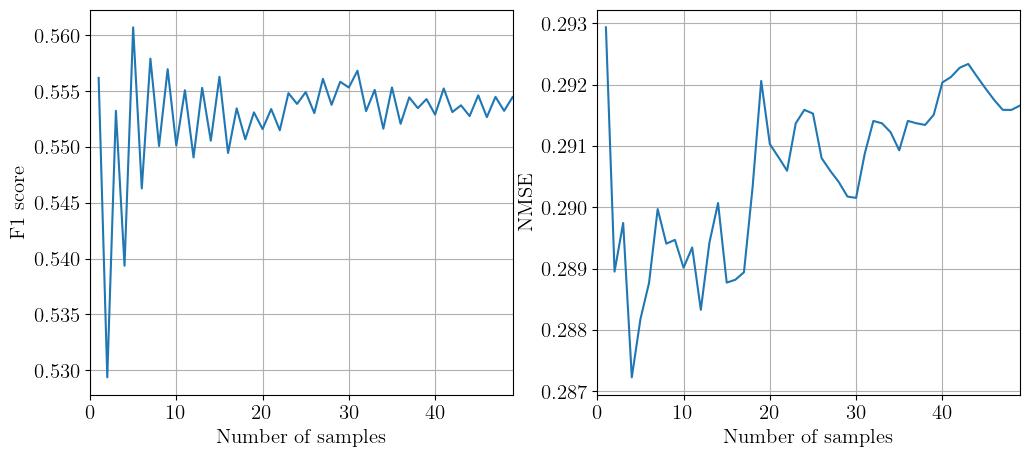

In [4]:
filename = f"outputs/bootstrap_deezer_ego_130_0.01_1_50_(0.3, 0.7)_heat_diffusion_filter.csv"
df = pd.read_csv(filename, sep=";", index_col=0).reset_index(drop=True)
for col in ["real_graph", "graph_est"]:
    df[col] = df[col].apply(lambda x: (np.array(eval(x)) > 0.5).astype(int))

print("Number of simulations:", df.seed.nunique())

th = 0.5
f1_scores = list()
nmse_scores = list()

x_axis = df.bootstrap_idx.sort_values().unique()
for b in x_axis:
    grouped = df[df["bootstrap_idx"] <= b].groupby("seed").mean()
    f1_scores.append(grouped.apply(lambda row: f1_score(row["real_graph"], row[f"graph_est"] > th), axis=1).mean())
    nmse_scores.append(grouped.apply(lambda row: np.sqrt(np.sum((row["real_theta"] - row[f"theta_est"]) ** 2) / np.sum(row["real_theta"] ** 2)), axis=1).mean())

# Plot f1 and nmse as function of the number of samples in different plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(x_axis + 1, f1_scores)
ax[0].set_xlabel("Number of samples")
ax[0].set_ylabel("F1 score")
ax[0].set_xlim(x_axis.min(), x_axis.max())
ax[0].grid()

ax[1].plot(x_axis + 1, nmse_scores)
ax[1].set_xlabel("Number of samples")
ax[1].set_ylabel("NMSE")
ax[1].set_xlim(x_axis.min(), x_axis.max())
ax[1].grid()
plt.show()

Number of simulations: 100


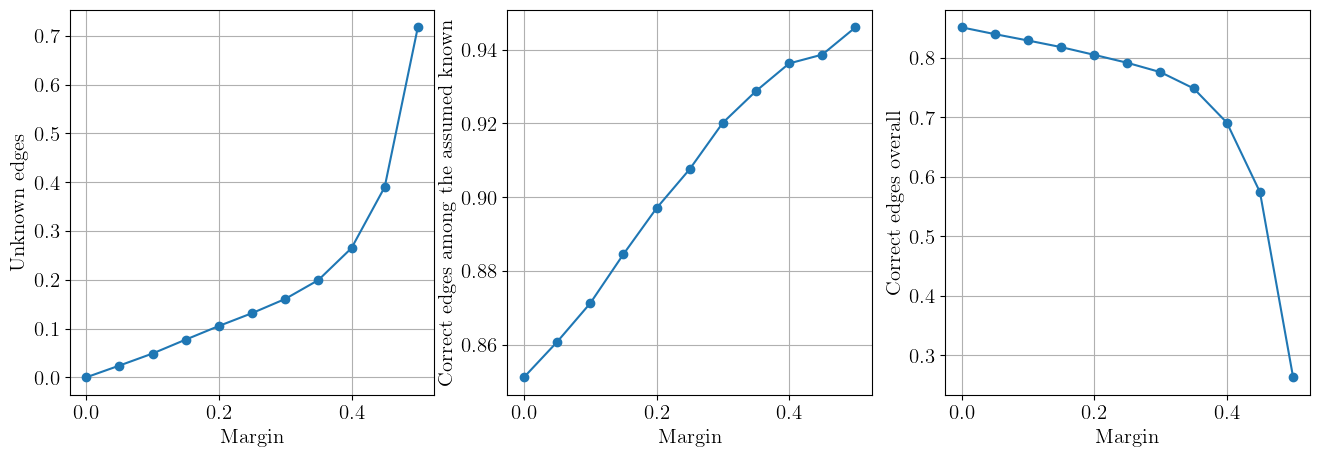

In [9]:
filename = f"outputs/bootstrap_deezer_ego_130_0.01_1_50_(0.3, 0.7)_heat_diffusion_filter.csv"
df = pd.read_csv(filename, sep=";", index_col=0).reset_index(drop=True)
for col in ["real_graph", "graph_est"]:
    # df[col] = df[col].apply(lambda x: (np.array(eval(x)) > 0.5).astype(int))
    df[col] = df[col].apply(lambda x: np.array(eval(x)))

print("Number of simulations:", df.seed.nunique())

def compute_metrics(pred, true_supp):
    idx_nan = np.isnan(pred)
    prop_unknown = round(np.sum(idx_nan) / len(idx_nan), 2)
    prop_known_correct = round(np.sum(pred[~ idx_nan] == true_supp[~ idx_nan]) / len(pred[~ idx_nan]), 2)
    prop_correct = round(np.sum(pred == true_supp) / len(pred), 2)
    return prop_unknown, prop_known_correct, prop_correct

def threshold_probabilities(probs, margin):
    pred = probs.copy()
    pred[pred >= (0.5 + margin)] = 1
    pred[pred <= (0.5 - margin)] = 0
    pred[(pred != 0) & (pred != 1)] = np.nan
    return pred

df_grouped = df.groupby("seed").mean()

margins = np.linspace(0, 0.5, 11)
metrics = {
    "prop_unknown": list(),
    "prop_known_correct": list(),
    "prop_correct": list()

}

for i, row in df_grouped.iterrows():
    for margin in margins:
        pred = threshold_probabilities(row["graph_est"], margin)
        prop_unknown, prop_known_correct, prop_correct = compute_metrics(pred, row["real_graph"])
        metrics["prop_unknown"].append(prop_unknown)
        metrics["prop_known_correct"].append(prop_known_correct)
        metrics["prop_correct"].append(prop_correct)

for key in metrics:
    metrics[key] = np.array(metrics[key]).reshape((-1, len(margins))).mean(axis=0)

fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ylabels = {
    "prop_unknown": "Unknown edges",
    "prop_known_correct": "Correct edges among the assumed known",
    "prop_correct": "Correct edges overall"

}
for i, metric in enumerate(["prop_unknown", "prop_known_correct", "prop_correct"]):
    ax[i].plot(margins, metrics[metric], "-o")
    ax[i].set_xlabel("Margin")
    ax[i].set_ylabel(ylabels[metric])
    ax[i].grid()
plt.show()

In [ ]:
# plot_l1_tuning("outputs/tuning_penaltytheta_deezer_ego_13_0.01_1_1.0_0.5_[1, 5, 10, 15]_(0.3, 0.7)_heat_diffusion_filter.csv",
#                graph_metric="f1",
#                figsize=(9, 5))